In [148]:
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta

import pandas as pd
import numpy as np
import pandas_datareader as pdr
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

In [149]:
def load_data(code, start_date, end_date):
    if end_date == datetime.today().strftime('%Y-%m-%d'):
        # data = fdr.DataReader(code, start_date)
        data = pdr.DataReader(code, 'yahoo', start_date)
    else:
        # data = fdr.DataReader(code, start_date, end_date)
        data = pdr.DataReader(code, 'yahoo', start_date, end_date)
    return data['Close'] # 종가만 남김.

In [150]:
def buy_etf(money, etf_price, last_etf_num, fee_rate, etf_rate):
    etf_num = money * etf_rate // etf_price
    etf_money = etf_num * etf_price
    etf_fee = (last_etf_num - etf_num) * etf_price * fee_rate if last_etf_num > etf_num else 0
    
    while etf_num > 0 and money < (etf_money + etf_fee):
        etf_num -= 1
        etf_money = etf_num * etf_price
        etf_fee = (last_etf_num - etf_num) * etf_price * fee_rate if last_etf_num > etf_num else 0
    purchase_money = etf_money + etf_fee
    
    return purchase_money, etf_num, etf_money

In [151]:
def return_acc_log_graph(df, codes, length):
    profit_df = df.pct_change()
    
    profit_acc_df = (1 + profit_df).cumprod() - 1
    
    profit_log_df = np.log(profit_df + 1)
    
    profit_acc_log_df = profit_log_df.cumsum()
    
    final_acc_log_df = profit_acc_log_df * 100
    
    # 그래프 출력
    for i in range(length):
        plt.plot(final_acc_log_df[codes[i]].index, final_acc_log_df[codes[i]], label='{}'.format(codes[i]))
    plt.plot(final_acc_log_df['backtest'].index, final_acc_log_df['backtest'], label='Backtest')
    
    plt.legend(loc='upper left')
    plt.show()

In [152]:
def last_day_of_month(any_date):
    next_month = any_date.replace(day=28) + timedelta(days=4)  # this will never fail
    
    return next_month - timedelta(days=next_month.day)

In [153]:
def make_new_df(df, interval, start_date, mode='none'):
    new_df = pd.DataFrame()
    while start_date <= df.index[-1]:
        if mode == 'last':
            temp_date = last_day_of_month(start_date)
        else:
            temp_date = start_date
            
        while temp_date not in df.index and temp_date < df.index[-1]:
            if mode == 'last':
                temp_date -= timedelta(days=1) # 영업일이 아닐 경우 1일씩 감소.
            else:
                temp_date += timedelta(days=1) # 영업일이 아닐 경우 1일씩 증가.
              
        new_df = new_df.append(df.loc[temp_date])
        start_date += relativedelta(months=interval) # interval 개월씩 증가.
        
    return new_df

In [154]:
def Drawdowns(df):
    df['all-time_high'] = df['cur_profit'].cummax()
    df['DD'] = (df['cur_profit'] / df['all-time_high'] - 1) * 100

    plt.plot(df.index, df['DD'], label='Drawdowns')
    plt.legend()
    plt.show()

    MDD = df['DD'].min()
    print("MDD: {} %".format(MDD))

    return df

In [155]:
def Drawdowns_for_HistoricalMarketStressPeriods(df):
    start_date = None
    StressPeriods_df = pd.DataFrame(columns=['Stress Period', 'Start', 'End', 'Portfolio'])

    for each in df.index:

        # Black Monday Period
        if date(1987, 9, 1) < each and each < date(1987, 12, 1):
            if start_date is None:
                stressPeriod = 'Black Monday Period'
                start_date = each
            end_date = each

        # Asian Crisis
        elif date(1997, 7, 1) < each and each < date(1998, 2, 1):
            if start_date is None:
                stressPeriod = 'Asian Crisis'
                start_date = each
            end_date = each

        # Russian Debt Default
        elif date(1998, 7, 1) < each and each < date(1998, 11, 1):
            if start_date is None:
                stressPeriod = 'Russian Debt Default'
                start_date = each
            end_date = each

        # Dotcom Crash
        elif date(2000, 3, 1) < each and each < date(2002, 11, 1):
            if start_date is None:
                stressPeriod = 'Dotcom Crash'
                start_date = each
            end_date = each

        # Subprime Crisis
        elif date(2007, 11, 1) < each and each < date(2009, 4, 1):
            if start_date is None:
                stressPeriod = 'Subprime Crisis'
                start_date = each
            end_date = each

        # COVID-19 Start
        elif date(2020, 1, 1) < each and each < date(2020, 4, 1):
            if start_date is None:
                stressPeriod = 'COVID-19 Start'
                start_date = each
            end_date = each

        # 데이터프레임 추가
        else:
            if start_date is not None:
                part_MDD = df.loc[start_date:end_date]['DD'].min()
                new_row = pd.DataFrame([(stressPeriod, datetime.strftime(start_date, '%Y-%m-%d'), datetime.strftime(start_date, '%Y-%m-%d'), '{:.2f} %'.format(part_MDD))], columns=['Stress Period', 'Start', 'End', 'Portfolio'])
                # new_row = pd.DataFrame([(stressPeriod, start_date, end_date, part_MDD)], columns=['Stress Period', 'Start', 'End', 'Portfolio'])
                StressPeriods_df = pd.concat([StressPeriods_df, new_row])
            start_date = None

    StressPeriods_df = StressPeriods_df.set_index('Stress Period')
    print(StressPeriods_df)

In [156]:
def Date_Diff(end_date, start_date):
    delta = relativedelta(end_date, start_date)
    result = ''

    if delta.years > 1:
        result += '{} years'.format(delta.years)
    elif delta.years == 1:
        result += '1 year'
    
    if delta.years >= 1:
        result += ' '
        
    if delta.months > 1:
        result += '{} months'.format(delta.months)
    elif delta.months == 1:
        result += '1 month'

    return result

In [157]:
def Drawdowns_for_Portfolio(df):
    start_date = None
    Portfolio_df = pd.DataFrame(columns=['Start', 'End', 'Length', 'Recovery By', 'Recovery Time', 'Underwater Period', 'Drawdown'])

    for each in df.index:
        if df['DD'][each] < 0:
            if start_date is None:
                start_date = each
                part_MDD = df['DD'][each]
                MDD_date = each

            if part_MDD > df['DD'][each]:
                part_MDD = df['DD'][each]
                MDD_date = each

            end_date = each
        else:
            if start_date is not None:
                # length = MDD_date - start_date
                # recoveryTime = end_date - MDD_date
                # underwaterPeriod = end_date - start_date
                length = Date_Diff(MDD_date, start_date)
                recoveryTime = Date_Diff(end_date, MDD_date)
                underwaterPeriod = Date_Diff(end_date, start_date)

                start_date = datetime.strftime(start_date, '%Y-%m-%d')
                MDD_date = datetime.strftime(MDD_date, '%Y-%m-%d')
                end_date = datetime.strftime(end_date, '%Y-%m-%d')

                new_row = pd.DataFrame([(start_date, MDD_date, length, end_date, recoveryTime, underwaterPeriod, part_MDD)], columns=['Start', 'End', 'Length', 'Recovery By', 'Recovery Time', 'Underwater Period', 'Drawdown'])
                Portfolio_df = pd.concat([Portfolio_df, new_row])
            start_date = None

    Portfolio_df = Portfolio_df.sort_values('Drawdown')
    Portfolio_df['Rank'] = Portfolio_df['Drawdown'].rank(method='min')
    Portfolio_df['Rank'] = Portfolio_df['Rank'].astype(int)
    Portfolio_df = Portfolio_df.set_index('Rank')
    print(Portfolio_df.iloc[0:10])

In [158]:
def GTAA5(df, codes):
    for code in codes:
        df['{} 10 Months Moving Average'.format(code)] = df[code].rolling(window=10).mean()

    return df[['{} 10 Months Moving Average'.format(code) for code in codes]]

In [159]:
def GTAA5_back_test(money: int, fee_rate: float, interval: int, codes: list, etf_rates: list, start_date: str, end_date: str = datetime.today().strftime('%Y-%m-%d')):
    
    start_date = datetime.strptime(start_date, '%Y-%m-%d') # 조회시작일
    end_date = datetime.strptime(end_date, '%Y-%m-%d') # 조회종료일
    
    etfs = []
    for code in codes:
        etfs.append(load_data(code, start_date, end_date))
    
    df = pd.concat(etfs, axis=1, keys=[code for code in codes])
    df = df.fillna(method='ffill')
    
    # print(df.isnull().sum())

    # Drawdonws를 위한 데이터프레임
    monthly_df_for_dd = make_new_df(df, 1, start_date, 'last')
    
    # 리밸런싱 날짜의 데이터만 new_df에 남깁니다.
    new_df = make_new_df(df, interval, start_date)

    MV_df = GTAA5(new_df.copy(), codes)
    check_df = MV_df.isna()

    etf_nums = [0 for i in range(len(etfs))]
    # etf_prices = [new_df[code][0] for code in codes]
    etf_prices = [0 for i in range(len(etfs))]
    etf_moneys = [0 for i in range(len(etfs))]
    
    # 각 etf 마다의 backtest
    # etf_backtest_df = pd.DataFrame()
    backtest_df = pd.DataFrame() # 백테스트를 위한 데이터프레임
    profit_df_for_dd = pd.DataFrame() # Drawdonws를 위한 기간별 이익 데이터프레임

    months = 0
    monthly_last_date = monthly_df_for_dd.index[months]
    for each in new_df.index:
        for i in range(len(etfs)):
            etf_prices[i] = new_df[codes[i]][each]
        
        # 보유 etf 매도
        for i in range(len(etfs)):
            money += etf_nums[i] * etf_prices[i]
        
        # etf 매입
        init_money = money
        for i in range(len(etfs)):
            if not (check_df['{} 10 Months Moving Average'.format(codes[i])][each]):
                if new_df[codes[i]][each] > MV_df['{} 10 Months Moving Average'.format(codes[i])][each]:
                    buy_money, etf_nums[i], etf_moneys[i] = buy_etf(init_money, etf_prices[i], etf_nums[i], fee_rate, etf_rates[i])
                    money -= buy_money
                else:
                    etf_nums[i] = 0

        total = money
        for i in range(len(etfs)):
            if not (check_df['{} 10 Months Moving Average'.format(codes[i])][each]):
                if new_df[codes[i]][each] > MV_df['{} 10 Months Moving Average'.format(codes[i])][each]:
                    total += etf_moneys[i]

        # new_row = pd.DataFrame([tuple([money for money in etf_moneys] + [each])], columns=([code for code in codes] + ['Date']))
        # etf_backtest_df = pd.concat([etf_backtest_df, new_row])

        # Drawdowns를 구하기 위한 계산
        while months < len(monthly_df_for_dd.index) and monthly_last_date < each + relativedelta(months=interval):
            cur_profit = money
            for j in range(len(etfs)):
                cur_profit += etf_nums[j] * monthly_df_for_dd[codes[j]][monthly_last_date]
                
            # profit_df_for_dd[monthly_last_date] = [int(cur_profit)]
            profit_df_for_dd[monthly_last_date] = [float(cur_profit)]
            
            months += 1
            if months >= len(monthly_df_for_dd.index):
                break
            monthly_last_date = monthly_df_for_dd.index[months]
            
        # backtest_df[each] = [int(total)]
        backtest_df[each] = [float(total)]

    # 행열을 바꿈
    backtest_df = backtest_df.transpose()
    backtest_df.columns = ['backtest', ]
    
    # Drawdowns를 위한 데이터프레임 정리
    profit_df_for_dd = profit_df_for_dd.transpose()
    profit_df_for_dd.columns = ['cur_profit', ]
    
    # 백테스트 결과 출력
    # print(backtest_df)

    # etf_backtest_df = etf_backtest_df.set_index('Date')
    # print(etf_backtest_df)
    
    # 최종 데이터 프레임, 3개의 지표와 백테스트 결과
    # final_df = pd.concat([etf_backtest_df, backtest_df], axis=1)
    final_df = pd.concat([new_df, backtest_df], axis=1)
    print(final_df)
    
    # CAGR 계산
    CAGRs = []
    for i in range(len(etfs)):
        delta = final_df.index[-1] - final_df.index[0]
        years = delta.days / 365
        CAGR = (final_df[codes[i]][-1] / final_df[codes[i]][0]) ** (1 / years) - 1
        CAGRs.append(CAGR)
    delta = final_df.index[-1] - final_df.index[0]
    years = delta.days / 365
    CAGR = (final_df['backtest'][-1] / final_df['backtest'][0]) ** (1 / years) - 1
    CAGRs.append(CAGR)
    
    # CAGR 출력
    for i in range(len(etfs)):
        print("{} CAGR: {} %".format(codes[i], CAGRs[i] * 100))
    print("Total CAGR: {} %".format(CAGRs[-1] * 100))
    
    # 복리수익률 그래프
    return_acc_log_graph(final_df, codes, len(etfs))
    # Drawdonws 그래프와 MDD
    dd_df = Drawdowns(profit_df_for_dd)
    Drawdowns_for_HistoricalMarketStressPeriods(dd_df)
    Drawdowns_for_Portfolio(dd_df)

C:\Users\User\AppData\Local\Temp\ipykernel_72980\2446890486.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(df.loc[temp_date])
C:\Users\User\AppData\Local\Temp\ipykernel_72980\2446890486.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(df.loc[temp_date])
C:\Users\User\AppData\Local\Temp\ipykernel_72980\2446890486.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(df.loc[temp_date])
C:\Users\User\AppData\Local\Temp\ipykernel_72980\2446890486.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(df.loc[temp_date])
C:\Users\User\AppData\Lo

                   SPY        EFA         IEF        DBC        VNQ  \
2007-01-03  141.369995  73.510002   82.680000  23.799999  77.120003   
2007-02-01  144.610001  74.860001   81.739998  23.900000  84.089996   
2007-03-01  140.509995  73.389999   83.279999  25.030001  80.680000   
2007-04-02  142.160004  76.500000   82.860001  25.129999  79.849998   
2007-05-01  148.669998  79.080002   82.959999  25.620001  78.559998   
...                ...        ...         ...        ...        ...   
2020-08-03  328.790009  63.259998  122.639999  13.070000  80.309998   
2020-09-01  352.600006  65.050003  121.820000  13.560000  81.809998   
2020-10-01  337.040009  64.019997  121.809998  12.900000  80.540001   
2020-11-02  330.200012  62.189999  120.190002  12.880000  78.419998   
2020-12-01  366.019989  71.800003  119.669998  13.900000  85.080002   

                backtest  
2007-01-03  10000.000000  
2007-02-01  10000.000000  
2007-03-01  10000.000000  
2007-04-02  10000.000000  
2007-05-01  

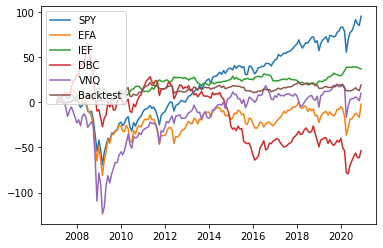

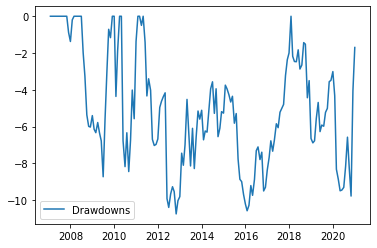

MDD: -10.74948733769947 %
                      Start         End Portfolio
Stress Period                                    
Subprime Crisis  2007-11-30  2007-11-30   -6.33 %
COVID-19 Start   2020-01-31  2020-01-31   -8.87 %
           Start         End           Length Recovery By    Recovery Time  \
Rank                                                                         
1     2011-05-31  2012-10-31  1 year 5 months  2017-12-29  5 years 1 month   
2     2008-07-31  2009-06-30        11 months  2009-10-30         4 months   
3     2010-05-28  2010-08-31         3 months  2010-12-31         4 months   
4     2010-01-29  2010-01-29                   2010-02-26                    
5     2007-11-30  2007-12-31          1 month  2008-01-31          1 month   
6     2011-03-31  2011-03-31                   2011-03-31                    

     Underwater Period   Drawdown  
Rank                               
1     6 years 6 months -10.749487  
2      1 year 2 months  -8.728905  
3    

C:\Users\User\AppData\Local\Temp\ipykernel_72980\1799366149.py:8: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if date(1987, 9, 1) < each and each < date(1987, 12, 1):
C:\Users\User\AppData\Local\Temp\ipykernel_72980\1799366149.py:15: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  elif date(1997, 7, 1) < each and each < date(1998, 2, 1):
C:\Users\User\AppData\Local\Temp\ipykernel_72980\1799366149.py:22: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts =

In [160]:
GTAA5_back_test(10_000, 0.002, 1, ['SPY', 'EFA', 'IEF', 'DBC', 'VNQ'], [0.2, 0.2, 0.2, 0.2, 0.2], '2007-01-01', '2021-01-01')